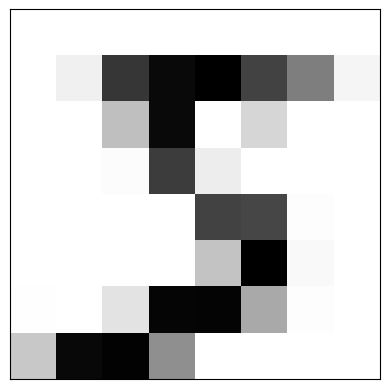

In [4]:
import MNIST_database as mnist
from matplotlib import pyplot as plt


#Choose the final size of your image dataset
size_final = 8

# data_zoom = mnist.MNISTData(size_initial=20, size_final=size_final, color_depth=5, flat=True)
data_zoom = mnist.MNISTData(size_initial=20, size_final=8, color_depth=8, flat=True)

x_train= data_zoom.x_train
y_train= data_zoom.y_train
x_test= data_zoom.x_test
x_test= data_zoom.y_test

ax = plt.subplot(1, 1 , 1)

plt.imshow(x_train[0].reshape(size_final,size_final), cmap='gray_r')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
import numpy as np
import tensorflow_model_optimization as tfmot

# Load your dataset here, e.g., x_train, y_train
# ...

# Define input shape
input_shape = (x_train.shape[-1],)

# Quantize the layers
def apply_quantization(layer):
    return tfmot.quantization.keras.quantize_annotate_layer(layer)

# Encoder
encoder_input = Input(shape=input_shape, name='encoder_input')
encoder_layer1 = apply_quantization(Dense(128, activation='relu', name='encoder_layer1'))(encoder_input)
encoder_layer2 = apply_quantization(Dense(64, activation='relu', name='encoder_layer2'))(encoder_layer1)
encoder_layer3 = apply_quantization(Dense(32, activation='relu', name='encoder_layer3'))(encoder_layer2)

# Decoder
decoder_input = Input(shape=(32,), name='decoder_input')
decoder_concat = Concatenate()([encoder_layer3, decoder_input])
decoder_layer1 = apply_quantization(Dense(64, activation='relu', name='decoder_layer1'))(decoder_concat)
decoder_layer2 = apply_quantization(Dense(128, activation='relu', name='decoder_layer2'))(decoder_layer1)
decoder_output = Dense(y_train.shape[-1], activation='linear', name='decoder_output')(decoder_layer2)

# Create the model
model = Model(inputs=[encoder_input, decoder_input], outputs=decoder_output)

# Apply quantization
model = tfmot.quantization.keras.quantize_apply(model)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
# Assume the decoder's input is the same as the encoder's output during training
model.fit([x_train, np.zeros((x_train.shape[0], 32))], y_train, epochs=10, batch_size=32)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import numpy as np
import tensorflow_model_optimization as tfmot

# Load your dataset here, e.g., x_train, y_train
# ...

# Define input shape
input_shape = (x_train.shape[-1],)

# Quantize the layers
def apply_quantization(layer):
    return tfmot.quantization.keras.quantize_annotate_layer(layer)

# Encoder
encoder_input = Input(shape=input_shape, name='encoder_input')
encoder_layer1 = apply_quantization(Dense(128, activation='relu', name='encoder_layer1'))(encoder_input)
encoder_layer2 = apply_quantization(Dense(64, activation='relu', name='encoder_layer2'))(encoder_layer1)
encoder_output = apply_quantization(Dense(32, activation='relu', name='encoder_layer3'))(encoder_layer2)

# Decoder
decoder_layer4 = apply_quantization(Dense(64, activation='relu', name='decoder_layer4'))(encoder_output)
decoder_layer5 = apply_quantization(Dense(128, activation='relu', name='decoder_layer5'))(decoder_layer4)
decoder_output = Dense(y_train.shape[-1], activation='linear', name='decoder_output')(decoder_layer5)

# Create the model
model = Model(inputs=encoder_input, outputs=decoder_output)

# Apply quantization
model = tfmot.quantization.keras.quantize_apply(model)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=32)


In [ ]:
# Get the weights and biases of the loaded model
for layer in model.layers:
    weights = layer.get_weights()
    print(f'Layer {layer.name}:')
    
    if len(weights) == 2:
        w, b = weights
        print(f'  Weights:\n{w}')
        print(f'  Biases:\n{b}')
    else:
        print('  No weights and biases.')

In [ ]:
# Get the weights and biases of the loaded model
for layer in loaded_model.layers:
    weights = layer.get_weights()
    print(f'Layer {layer.name}:')
    
    if len(weights) == 2:
        w, b = weights
        print(f'  Weights:\n{w}')
        print(f'  Biases:\n{b}')
    else:
        print('  No weights and biases.')

# new

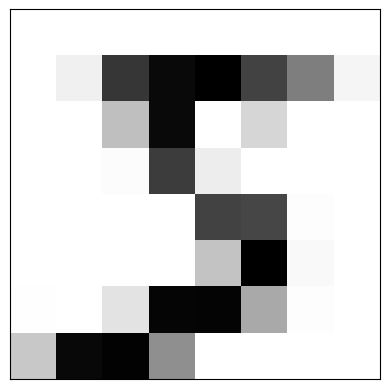

In [1]:
import MNIST_database as mnist
from matplotlib import pyplot as plt


#Choose the final size of your image dataset
size_final = 8

# data_zoom = mnist.MNISTData(size_initial=20, size_final=size_final, color_depth=5, flat=True)
data_zoom = mnist.MNISTData(size_initial=20, size_final=8, color_depth=8, flat=True)

x_train= data_zoom.x_train
y_train= data_zoom.y_train
x_test= data_zoom.x_test
x_test= data_zoom.y_test

ax = plt.subplot(1, 1 , 1)

plt.imshow(x_train[0].reshape(size_final,size_final), cmap='gray_r')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Layer
from tensorflow.keras.models import Model
import numpy as np

# Load your dataset here, e.g., x_train, y_train
# ...

# Define input shape
input_shape = (x_train.shape[-1],)

# Set bit width
BIT_WIDTH = 5

# Define custom quantization function
def custom_quantization(x, min_val, max_val):
    return tf.quantization.fake_quant_with_min_max_vars(x, min_val, max_val, num_bits=BIT_WIDTH)

# Create custom layer with custom quantization
class CustomQuantizedDense(Layer):
    def __init__(self, units, activation, **kwargs):
        super(CustomQuantizedDense, self).__init__(**kwargs)
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel", (input_shape[-1], self.units))
        self.bias = self.add_weight("bias", (self.units,))
        self.min_val = self.add_weight("min_val", shape=(), trainable=False)
        self.max_val = self.add_weight("max_val", shape=(), trainable=False)

    def call(self, inputs):
        quantized_kernel = custom_quantization(self.kernel, self.min_val, self.max_val)
        quantized_bias = custom_quantization(self.bias, self.min_val, self.max_val)
        output = tf.matmul(inputs, quantized_kernel) + quantized_bias
        return self.activation(output)

# Encoder
encoder_input = Input(shape=input_shape, name='encoder_input')
encoder_layer1 = CustomQuantizedDense(128, activation=tf.nn.relu, name='encoder_layer1')(encoder_input)
encoder_layer2 = CustomQuantizedDense(64, activation=tf.nn.relu, name='encoder_layer2')(encoder_layer1)
encoder_output = CustomQuantizedDense(32, activation=tf.nn.relu, name='encoder_layer3')(encoder_layer2)

# Decoder
decoder_layer4 = CustomQuantizedDense(64, activation=tf.nn.relu, name='decoder_layer4')(encoder_output)
decoder_layer5 = CustomQuantizedDense(128, activation=tf.nn.relu, name='decoder_layer5')(decoder_layer4)
decoder_output = CustomQuantizedDense(y_train.shape[-1], activation=tf.nn.relu, name='decoder_output')(decoder_layer5)

# Create the model
model = Model(inputs=encoder_input, outputs=decoder_output)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=32)


Epoch 1/10
1875/1875 [==============================] - 12s 5ms/step - loss: 0.1000
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1000
Epoch 3/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1000
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1000
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1000
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1000
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1000
Epoch 8/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1000
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1000
Epoch 10/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1000


In [ ]:
# Assuming your QAT model is stored in the variable `qat_model`
qat_model = model
# Convert the QAT model to a fully quantized model
quantized_model = torch.quantization.convert(qat_model)

# Iterate through the layers and obtain quantized weights
for name, module in quantized_model.named_modules():
    if hasattr(module, 'weight'):
        quantized_weight = module.weight()
        print(f"Layer: {name}, Quantized Weight: {quantized_weight}, Dtype: {quantized_weight.dtype}")


In [3]:
# Get the weights and biases of the loaded model
for layer in model.layers:
    print(f'Layer {layer.name}:')
    
    if isinstance(layer, CustomQuantizedDense):
        w, b = layer.kernel, layer.bias
        print(f'  Weights:\n{w}')
        print(f'  Biases:\n{b}')
    else:
        weights = layer.get_weights()
        if len(weights) == 2:
            w, b = weights
            print(f'  Weights:\n{w}')
            print(f'  Biases:\n{b}')
        else:
            print('  No weights and biases.')


Layer encoder_input:
  No weights and biases.
Layer encoder_layer1:
  Weights:
<tf.Variable 'encoder_layer1/kernel:0' shape=(64, 128) dtype=float32, numpy=
array([[ 0.16362126, -0.16021436, -0.13087237, ...,  0.01030259,
         0.10924523, -0.06339029],
       [ 0.02260731, -0.10997149, -0.15902293, ...,  0.15956075,
         0.14734708, -0.0841625 ],
       [ 0.05756378, -0.17191501, -0.10418157, ...,  0.11823379,
         0.03678961,  0.15261434],
       ...,
       [-0.1450727 , -0.13419013, -0.09763443, ...,  0.08610259,
        -0.07819551,  0.13991414],
       [-0.11880619, -0.09985001, -0.08469439, ...,  0.09752624,
        -0.1198956 ,  0.11012895],
       [-0.14261287,  0.01854697,  0.0420379 , ..., -0.00986001,
         0.0053416 ,  0.15654297]], dtype=float32)>
  Biases:
<tf.Variable 'encoder_layer1/bias:0' shape=(128,) dtype=float32, numpy=
array([ 0.02863955,  0.0500284 ,  0.00888328,  0.13266937,  0.05329411,
        0.04863629,  0.09857111,  0.00917105, -0.0209738 , -0

In [4]:
# Save the model to a file
model.save('my_model.h5')

NotImplementedError: 
Layer CustomQuantizedDense was created by passing
non-serializable argument values in `__init__()`,
and therefore the layer must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config

In [ ]:
# Load the model from the saved file
loaded_model = tf.keras.models.load_model('my_model.h5')